In [2]:
from pathlib import Path
import glob
import pandas as pd
import numpy as np
import skimage
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray


images_dir = Path('/content/drive/MyDrive/kaggle/rice/ricedisease')
folders = [directory for directory in images_dir.iterdir() if directory.is_dir()]
categories = [fo.name for fo in folders]

images = []
flat_data = []
target = []
target_names=categories

for i, direc in enumerate(folders):
  for file in direc.iterdir():
    image = skimage.io.imread(file)
    image_resized=resize(image,(224,224))
    
    images.append(image_resized)
    flat_data.append(image_resized.flatten())
    target.append(i)

flat_data = np.array(flat_data)
target = np.array(target)
images = np.array(images)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, target, test_size=0.3,random_state=109)

In [101]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet')

In [102]:
base_model.trainable = False

In [126]:
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(4, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)


In [127]:
dataAugmentaion = ImageDataGenerator(rotation_range = 40, zoom_range = 0.20, 
fill_mode = "nearest", shear_range = 0.20, horizontal_flip = True, 
width_shift_range = 0.2, height_shift_range = 0.2)

In [128]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


In [129]:
history=model.fit_generator(dataAugmentaion.flow(X_train, y_train, batch_size = 16),
 validation_data = (X_test, y_test), steps_per_epoch = len(X_train) // 16,
 epochs = 30)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
7/7 [==============================] - 23s 3s/step - loss: 3.1879 - accuracy: 0.3715 - val_loss: 0.9553 - val_accuracy: 0.6667
Epoch 2/30
7/7 [==============================] - 17s 2s/step - loss: 0.9300 - accuracy: 0.6640 - val_loss: 0.4427 - val_accuracy: 0.8542
Epoch 3/30
7/7 [==============================] - 17s 2s/step - loss: 0.4656 - accuracy: 0.8275 - val_loss: 0.4873 - val_accuracy: 0.8333
Epoch 4/30
7/7 [==============================] - 16s 2s/step - loss: 0.3959 - accuracy: 0.7849 - val_loss: 0.3612 - val_accuracy: 0.8542
Epoch 5/30
7/7 [==============================] - 16s 2s/step - loss: 0.3412 - accuracy: 0.8897 - val_loss: 0.5953 - val_accuracy: 0.7292
Epoch 6/30
7/7 [==============================] - 16s 2s/step - loss: 0.3783 - accuracy: 0.8343 - val_loss: 0.6036 - val_accuracy: 0.8125
Epoch 7/30
7/7 [==============================] - 16s 2s/step - loss: 0.2268 - accuracy: 0.9108 - val_loss: 0.5790 - val_accuracy: 0.7917
Epoch 8/30
7/7 [==================

In [130]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model.save('ricemodel_inception.h5')

In [131]:
y_pred = model.predict(X_test)
print("Predicted values:")
print(y_pred)

Predicted values:
[[4.77132801e-07 1.66075290e-06 1.54319487e-03 9.98454690e-01]
 [9.99915838e-01 2.79150245e-05 1.63232289e-06 5.45495714e-05]
 [8.19773413e-06 8.95851851e-03 3.04719191e-02 9.60561335e-01]
 [9.99968767e-01 3.05480862e-05 3.84311988e-07 3.54636825e-07]
 [1.11569953e-07 4.11218898e-05 9.93012607e-01 6.94618607e-03]
 [1.33279152e-02 9.67323482e-01 1.36013906e-02 5.74721629e-03]
 [9.90406454e-01 7.11877365e-03 5.24282550e-05 2.42233276e-03]
 [1.04555486e-09 9.99992728e-01 7.20106618e-06 9.60525313e-08]
 [3.22489382e-06 1.28010334e-03 3.73197123e-02 9.61396992e-01]
 [1.47340057e-10 9.99993443e-01 6.50398761e-06 2.62968118e-08]
 [9.70147573e-11 9.99994278e-01 4.51884625e-06 1.18926550e-06]
 [4.35401262e-07 4.15263321e-06 7.22703617e-03 9.92768407e-01]
 [5.17300237e-03 8.30048263e-01 1.39078990e-01 2.56997570e-02]
 [1.22040154e-04 1.09367281e-01 3.16269726e-01 5.74240983e-01]
 [1.00000000e+00 2.91369068e-10 1.76407122e-09 3.38452866e-09]
 [3.19687956e-08 9.80096638e-01 1.988

In [132]:
import cv2
import itertools
import random
from collections import Counter
from glob import iglob
import os


def load_image(filename):
    img = cv2.imread(os.path.join(filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255
    
    return img

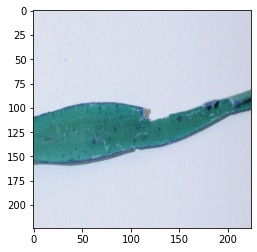

Predicted Disease is Leaf smut


In [143]:
import matplotlib.pyplot as plt


%matplotlib inline
img = load_image('/content/drive/MyDrive/kaggle/rice/ricedisease/Leaf smut/DSC_0327.JPG')
p = model.predict(np.asarray([img]))[0]
plt.imshow(img)    
plt.show()
k = target_names
class_idx = np.argmax(p)
s = [str(i) for i in p] 
a = int(class_idx) 
print("Predicted Disease is", k[a])